In [4]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [5]:
TRAIN_PATH = "/content/GTSRB/train_modified"
TEST_PATH  = "/content/GTSRB/test_modified"


In [6]:
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        for file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(idx)

    return images, np.array(labels), class_names


In [8]:
!unzip /content/GTSRB.zip -d /content/

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: /content/GTSRB/test_modified/26/04314.png  
  inflating: /content/GTSRB/test_modified/26/04698.png  
 extracting: /content/GTSRB/test_modified/26/05000.png  
 extracting: /content/GTSRB/test_modified/26/05176.png  
 extracting: /content/GTSRB/test_modified/26/05251.png  
 extracting: /content/GTSRB/test_modified/26/06200.png  
 extracting: /content/GTSRB/test_modified/26/06258.png  
 extracting: /content/GTSRB/test_modified/26/06338.png  
 extracting: /content/GTSRB/test_modified/26/07080.png  
 extracting: /content/GTSRB/test_modified/26/08677.png  
  inflating: /content/GTSRB/test_modified/26/08702.png  
 extracting: /content/GTSRB/test_modified/26/09019.png  
 extracting: /content/GTSRB/test_modified/26/09177.png  
 extracting: /content/GTSRB/test_modified/26/09570.png  
 extracting: /content/GTSRB/test_modified/26/09927.png  
 extracting: /content/GTSRB/test_modified/26/10096.png  
 extracting: /content/GTSRB/test_

In [9]:
X_train, y_train, class_names = load_images_from_folder(TRAIN_PATH)
X_test, y_test, _ = load_images_from_folder(TEST_PATH)


In [10]:
sift = cv2.SIFT_create()

def extract_sift_features(images):
    descriptors_list = []
    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        descriptors_list.append(des)
    return descriptors_list


In [11]:
train_desc = extract_sift_features(X_train)
test_desc  = extract_sift_features(X_test)


In [12]:
K_STAR_GTSRB = 400


In [13]:
all_descriptors = np.vstack([d for d in train_desc if d is not None])

kmeans = KMeans(n_clusters=K_STAR_GTSRB, random_state=0)
kmeans.fit(all_descriptors)


KMeans(n_clusters=400, random_state=0)

In [14]:
def build_bovw_histograms(descriptors_list, kmeans, K):
    histograms = []
    for descriptors in descriptors_list:
        hist = np.zeros(K)
        if descriptors is not None:
            labels = kmeans.predict(descriptors)
            for label in labels:
                hist[label] += 1
        histograms.append(hist)
    return np.array(histograms)


In [15]:
X_train_bovw = build_bovw_histograms(train_desc, kmeans, K_STAR_GTSRB)
X_test_bovw  = build_bovw_histograms(test_desc, kmeans, K_STAR_GTSRB)


In [16]:
k_STAR = 3


In [17]:
knn = KNeighborsClassifier(n_neighbors=k_STAR)
knn.fit(X_train_bovw, y_train)

knn_preds = knn.predict(X_test_bovw)
knn_acc = accuracy_score(y_test, knn_preds)

print("✅ k-NN Accuracy στο GTSRB:", knn_acc)


✅ k-NN Accuracy στο GTSRB: 0.27382753403933435


In [18]:
print(classification_report(y_test, knn_preds, target_names=class_names))


              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.10      0.46      0.16       114
          10       0.33      0.60      0.42       104
          11       0.54      0.48      0.51        66
          12       0.32      0.34      0.33       109
          13       0.31      0.47      0.38       114
          14       0.48      0.26      0.34        42
          15       0.14      0.18      0.16        33
          16       0.29      0.17      0.22        23
          17       0.36      0.46      0.40        57
          18       0.17      0.15      0.16        61
          19       0.21      0.44      0.29         9
           2       0.45      0.34      0.39       118
          20       0.10      0.21      0.14        14
          21       0.10      0.07      0.08        14
          22       0.00      0.00      0.00        19
          23       0.09      0.04      0.06        23
          24       0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


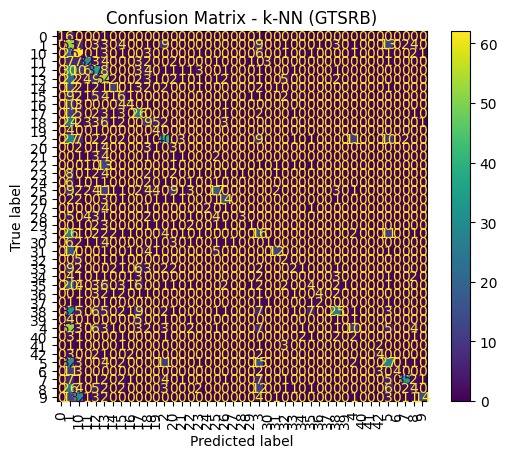

In [19]:
cm = confusion_matrix(y_test, knn_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix - k-NN (GTSRB)")
plt.show()


In [20]:
df = pd.DataFrame({
    "Model": ["k-NN"],
    "K_STAR": [K_STAR_GTSRB],
    "k_STAR": [k_STAR],
    "Accuracy": [knn_acc]
})

df.to_csv("experiment_2_knn_GTSRB_result.csv", index=False)
df


,Model,K_STAR,k_STAR,Accuracy
0,k-NN,400,3,0.273828
